<a href="https://colab.research.google.com/github/ellenmatt/DD2365-aflum/blob/main/tempogram_fingerprint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [397]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [398]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import glob
import os, sys, time
# from scipy.signal import find_peaks
from scipy.ndimage import maximum_filter
import os


**Testar med klassen i den här filen till en början**

## Class

In [399]:
class SoundFile:
  """
    A class for handling audio files and performing operations such as Short-Time Fourier Transform (STFT)
    computation, and spectrogram anchor extraction and more. Planning to add support for chromagram and tempogram.

    Attributes:
    - path: str, file path to the audio.
    - mono_sound: np.array, mono audio signal data.
    - frame_rate: int, sample rate of the audio file.
    - times: np.array, time values corresponding to the STFT (computed after calling `compute_stft`).
    - freqs: np.array, frequency values corresponding to the STFT (computed after calling `compute_stft`).
    - stft: np.array, the magnitude of the Short-Time Fourier Transform.
    - spectrogram: np.array, the spectrogram derived from the STFT magnitude.
    - time_index_list: np.array, placeholder for storing specific time indices  (This was from Theo's test code, can modify my code to use these instead if that helps)
    - freq_index_list: np.array, placeholder for storing specific frequency indices (Same as above ^).

    Methods:
    - print_info(): Prints basic information about the sound file.
    - compute_stft(window_size, hop_size, window_type): Computes the STFT of the mono audio signal,
                    and stores both the STFT results and the corresponding spectrogram.
    - compute_log_bins_indices(num_bins, start_freq, nyquist_freq): Converts the frequency axis into
                    logarithmic scale and returns bin boundaries based on the specified number of bins.
    - extract_spectrogram_peaks(num_bins, filter_size): Extracts local maxima from the spectrogram
                    by dividing it into logarithmic frequency bins and applying a filter to detect
                    neighbourhood peaks.
    - compute_hash_table(time_window_start, time_window_end, freq_window_start, freq_window_end):
                    Computes and stores the hash table of fingerprints by pairing anchors from the
                    "extract_spectrogram_peaks" method according to some sliding window defined by user.
    - plot_spectrogram_with_peaks(): Plots histogram with anchors visible, (duh)
    """

  def __init__(self, path, mono_sound, frame_rate):
    """
      Initializes the SoundFile object with the provided path, mono sound data, and frame rate.
      More parameters can be stored later on depending on the users needs.

      Parameters:
      - path: str, file path to the audio.
      - mono_sound: np.ndarray, mono audio signal data.
      - frame_rate: int, sample rate of the audio file.
    """
    self.path = path
    self.mono_sound = mono_sound
    self.frame_rate = frame_rate
    self.times = None
    self.freqs = None
    self.stft = None
    self.spectrogram = None
    self.time_index_list = None
    self.freq_index_list = None
    self.peak_coords = None
    self.hash_table = {}
    self.offset_times_dict = {}
    self.nr_of_anchor_pairs = 0


  def print_info(self):
    """
      Print basic information of the soundfile. Want to add prints for when we have chromagram and tempogram for debugging purposes.
    """
    print(f"Path: {self.path}")
    print(f"Frame rate: {self.frame_rate}")
    print(f"Mono sound: {self.mono_sound.shape}")
    if self.stft is not None:
      print(f"Times: {self.times.shape}")
      print(f"Frequencies: {self.freqs.shape}")
      print(f"STFT: {self.stft.shape}")

  #  all of these functions don't have to be tied to this class, we can move them later on if we feel that is better, which will likely be the case if we also use chromagrams and tempograms

  def compute_stft(self, window_size=1024, hop_size=32, window_type='hamming'):
    """
      Computes the Short-Time Fourier Transform (STFT) for the audio data using the specified window size, hop size, and window type.
      The stft array and it's corresponding time and frequency axis are stored as class parameters, and the corresponding spectrogram
      is also computed and stored.

      Parameters:
        - window_size: int, size of the window for STFT (default 1024).
        - hop_size: int, hop size for the sliding window (default 32).
        - window_type: str, type of window function to apply (default 'hamming').
    """
    window = scipy.signal.get_window(window_type, window_size)
    self.freqs, self.times, Zxx = signal.stft(self.mono_sound,
                            fs=self.frame_rate,
                            window=window,
                            nperseg=window_size,
                            noverlap=int(window_size - hop_size))
    self.stft = np.abs(Zxx)
    self.spectrogram = 20 * np.log10(np.abs(self.stft))

  def compute_log_bins_indices(self, num_bins, start_freq=20, nyquist_freq=4096):
    """
      Converts the frequency axis to a logarithmic scale, and returns the bin indices corresponding to logarithmic bins.
      This is important as logarithmic spacing helps capture more detail in the lower frequency ranges which human auditory
      perception is more sensitive to.

      Parameters:
      - num_bins: int, number of logarithmic bins.
      - start_freq: float, starting frequency for the logarithmic scale (default 20 Hz).
      - nyquist_freq: float, Nyquist frequency (default 4096 Hz).
    """
    # Range from 20 Hz to 20000 Hz is log(20) to log(20000), meaing 1.3 to 4.3
    # if we work from 20 Hz then we might have to adjust some code elsewhere, or we could maybe change it to 0 to 4096, but 0 is undefined in log space right?
    # We want to split this into N bins --> linear_bins = [((log(start) - log(end)) / N) * bin_id for bin_id in range(N)]

    # We then want to go back to log scale, by taking
    # log_bins = [10^linear_bin for linear_bin in linear_bins], but no guaranteee that these values exist in freqs so find the closest match.
    # for N=8 --> [20, 40, 80, 160, 320, 640, 1280, 2560, 4096] so bin1=freq[20:40], bin2=freq[40:80], bin3=freq[80:160], ..., bin8=freq[2560:4096]
    if self.freqs is None:
      raise ValueError("Frequencies not computed. Call `compute_stft` first.")

    # Create array of indices on the linear scale that are uniformly spaced on the log scale between the start and stop values, in our case log(20) and log(4096).
    boundary_points = np.logspace(np.log10(start_freq), np.log10(nyquist_freq), num_bins+1) # +1 as log_space generates N points, but we need bins so we need one more

    # Find where these boundary points exist in freqs
    bin_idx = np.searchsorted(self.freqs, boundary_points)  # if the value does not exist it will find the closest spot.
    return bin_idx

  def extract_spectrogram_peaks(self, num_bins, filter_size=(20, 20)):
    """
      Extracts local maxima from the spectrogram by dividing it into logarithmic frequency bins and applying a max filter to detect peaks.

      Detailed Algorithm Explanation:
      I create a zero array with shape stft, I then iterate over it and find all maximum values for each log-scaled frequency bin in each time step,
      giving me an array of all zeros except bin maximum values. I then apply a max filter to this array, splitting the image into neighbourhoods
      and only keeping the single biggest value per neighbourhood. I then extract the coordinates of these maximum values, storing them in a 2d array
      where each element is a 1d array (freq, time).

      Parameters:
        - num_bins: int, number of logarithmic frequency bins.
        - filter_size: tuple[int, int], size of the maximum filter applied to detect local peaks.
    """
    if self.stft is None:
      raise ValueError("STFT not computed. Call `compute_stft` first.")

    # Step 1: Initialize an array of zeros with the same shape as self.stft
    peaks = np.zeros_like(self.stft)
    #print(f"peaks before freq_bin loop: {peaks.shape}")

    # Step 2: Get the log-scaled bin indices
    log_bins_idx = self.compute_log_bins_indices(num_bins)

    # Step 3: Iterate over frequency bins
    for bin_start, bin_end in zip(log_bins_idx[:-1], log_bins_idx[1:]):
      # Get the bin segment of the spectrogram corresponding to this frequency range
      bin_segment = self.stft[bin_start:bin_end, :]  # shape: (bin_size, time)

      # For each time step, find the peak frequency in this bin segment
      for t_idx in range(bin_segment.shape[1]):  # Loop over time frames
        # Find the index of the maximum value in the bin segment for this time frame
        max_peak_idx = np.argmax(bin_segment[:, t_idx])

        # Step 4: Store the maximum value in the zero array at the corresponding location
        peaks[bin_start + max_peak_idx, t_idx] = self.stft[bin_start + max_peak_idx, t_idx]

    # Step 5: Apply a maximum filter to keep only local maxima in neighborhoods
    filtered_peaks = maximum_filter(peaks, size=filter_size)

    # Step 6: Extract coordinates of the local maximums
    self.peak_coords = np.argwhere((filtered_peaks == peaks) & (peaks > 0))

    # Return the (frequency, time) points where local maximums were found
    # return peak_coords    # Could be stored as class parameter instead.


  def compute_hash_table(self, time_window_start = 0, time_window_end = 100, freq_window_start = -99999, freq_window_end = 99999):
    """
      Computes the hash_table containing the fingerprints bases on the peaks list provided.

      Parameters:
        - peaks: an array containing the anchors computed in "extract_spectogram_peaks".
        - time_window_start: The time offset from which the pairing window starts, defaulting to zero for no offset.
        - time_window_end: The time offset at which the pairing window ends, defaulting to 100.
        - freq_window_start: The frequency offset from which the pairing window starts, defaulting to -100 to ignore frequency.
        - freq_window_end: The frequency offset from which the pairing window ends, defaulting to 99999 to ignore frequency.
    """

    if self.peak_coords is None:
      raise ValueError("Peaks not computed. Call `extract_spectrogram_peaks` first.")

    # Goes through every pair of anchors (not optimal)
    for i in range(len(self.peak_coords)):
      for other in range(len(self.peak_coords)):

        # Calculating difference in time and frequency
        diff_time = self.peak_coords[other][1] - self.peak_coords[i][1]
        diff_freq = self.peak_coords[other][0] - self.peak_coords[i][0]


        if time_window_start < diff_time < time_window_end:# and freq_window_start < diff_freq < freq_window_end:
          self.nr_of_anchor_pairs += 1

          # Adding pair to hash table
          if self.peak_coords[i][0] in self.hash_table.keys():
            self.hash_table[self.peak_coords[i][0]].append(self.peak_coords[other][0] + diff_time/1000)
          else:
            self.hash_table[self.peak_coords[i][0]] = [self.peak_coords[other][0] + diff_time/1000]

          # Adding time to beginning of file to hash table
          self.offset_times_dict[(self.peak_coords[i][0], self.peak_coords[other][0])] = self.peak_coords[i][1]


  def plot_spectrogram_with_peaks(self):
    """
    Plots the spectrogram of the sound file and overlays the detected peaks.

    Parameters:
      - sound_file: SoundFile, the sound file object containing the spectrogram.
      - peaks: np.ndarray, 2D array of peak coordinates (frequency index, time index).
    """
    plt.figure(figsize=(12, 6))

    # Plot the spectrogram
    plt.imshow(self.spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Magnitude (dB)')
    plt.title('Spectrogram with Peaks')
    plt.xlabel('Time (frames)')
    plt.ylabel('Frequency (bins)')

    # Unpack the peaks into frequency and time index lists for plotting
    freq_indices = self.peak_coords[:, 0]  # First column of the array is frequency
    time_indices = self.peak_coords[:, 1]  # Second column is time

    # Overlay the peaks on the spectrogram
    plt.scatter(time_indices, freq_indices, color='red', s=10, marker='o', label='Peaks')

    plt.legend()
    plt.show()




In [400]:
def load_sound_files(sound_dir, file_format='wav', frame_rate=8192):
  """
  Load sound files from a directory, convert to mono, and resample.
  """
  sound_files = []
  for audio_file_path in glob.glob(f"{sound_dir}/*.{file_format}"):
      # Load audio as a mono signal with the given frame rate, defaulted to 8192 as what defines a song is under the Nyquist frequency of 4096 Hz
      mono_sound, sr = librosa.load(audio_file_path, sr=frame_rate, mono=True)
      sound_file = SoundFile(path=audio_file_path, mono_sound=mono_sound, frame_rate=frame_rate)
      sound_files.append(sound_file)
  return sound_files



##Lite funktioner

In [401]:
def make_tempogram(audio_path, start_time=0, segment_duration=0):
    """
    Load audio samples and compute tempogram
    """
    if start_time or segment_duration:
        y, sr = librosa.load(audio_path, offset=start_time, duration=segment_duration)
    else:
        y, sr = librosa.load(audio_path)

    duration = librosa.get_duration(y=y, sr=sr)
    onset_envelope = librosa.onset.onset_strength(y=y, sr=sr)
    tempogram = librosa.feature.tempogram(y=y, sr=sr, onset_envelope=onset_envelope)

    return tempogram, sr, duration

In [402]:
def compute_anchors(tempogram, sr):
    """
    Computes anchors in tempogram by checking the max energy in each time-tempo box
    """
    hop_length = 512
    num_tempo_in_box = 30
    num_time_in_box = 60

    tempo_list = []
    time_list = []

    for tempo_box in range(0, tempogram.shape[0], num_tempo_in_box):
        for time_box in range(0, tempogram.shape[1], num_time_in_box):
            tempogram_box = tempogram[tempo_box:tempo_box + num_tempo_in_box, time_box:time_box + num_time_in_box]
            max_index = np.argmax(tempogram_box)

            local_tempo_index, local_time_index = np.unravel_index(max_index, tempogram_box.shape)

            tempo_list.append(tempo_box + local_tempo_index)
            time_list.append((time_box + local_time_index) * hop_length / sr)  # Time in seconds

    return time_list, tempo_list


In [403]:
def compute_fingerprints(time_list, tempo_list):
    """
    Creates fingerprints using anchors.
    Parameters:
      - time_list: list of times for the anchors
      - tempo_list: list of tempos for the anchors
    """
    fingerprints = []
    time_window = 5
    tempo_window = 1

    for i in range(len(tempo_list)):
        for j in range(i + 1, len(tempo_list)):
            if abs(time_list[j] - time_list[i]) < time_window and abs(tempo_list[j] - tempo_list[i]) < tempo_window:

                fingerprint = (tempo_list[i], tempo_list[j], time_list[j] - time_list[i])
                fingerprints.append((time_list[i], fingerprint))
    return fingerprints


In [404]:
def compare_fingerprints(query_fingerprints, stored_fingerprints):
    matches = 0
    for query_fingerprint in query_fingerprints:
        if query_fingerprint in stored_fingerprints:
            matches += 1
    return matches / len(query_fingerprints) # andel rätt

In [405]:
def compare_fingerprintsLab3(Fq1, Fd):
    """
    Comparing fingerprints from two files.
    """
    matches = 0
    for hash in Fq1:
        for other_hash in Fd:
            d = np.abs(hash[1][0] - other_hash[1][0]) + np.abs(hash[1][1] - other_hash[1][1]) + np.abs(hash[1][2] - other_hash[1][2])
            if d == 0:
                matches += 1

    return matches

**Testning**

In [406]:

sound_dir = "/content/drive/MyDrive/KTH/data/"
sound_files = load_sound_files(sound_dir)

# Put all data files in an array
data = [sound_files[i] for i in range(0, len(sound_files))]
query_file_no_noise = sound_files[6]
query_file_with_noise = sound_files[7]

all_fingerprints = []
for i in range(len(data)):
    data_name = data[i].path.split("/")[-1]
    print(data_name)
    path = os.path.join(sound_dir, data_name)
    tempogram, sr, duration = make_tempogram(path)
    time_list, tempo_list = compute_anchors(tempogram, sr)
    fingerprints = compute_fingerprints(time_list, tempo_list)

    all_fingerprints.append(fingerprints)



Q1.wav
Q5.wav
Q4.wav
Q3.wav
Q2.wav
Q6.wav
Q6query.wav
Q6querywithnoise.wav
Plini - Electric Sunrise (Audio).wav
Hardwell feat. Amba Shepherd - Apollo.wav
Dimitri Vegas, Moguai & Like Mike feat. Julian Peretta - Body Talk (Mammoth).wav
Chappell Roan - HOT TO GO!.wav


In [407]:
match_dict = {}
query = all_fingerprints[7]
for i in range(len(all_fingerprints)):

    match_fingerprints = compare_fingerprintsLab3(query, all_fingerprints[i])
    match_dict[i] = match_fingerprints


max_key = max(match_dict, key=match_dict.get)
max_score = match_dict[max_key]
print(f'Max number of matches are {max_score}, for audio {max_key}')
print(match_dict)


Max number of matches are 31, for audio 11
{0: 11, 1: 9, 2: 9, 3: 6, 4: 9, 5: 9, 6: 28, 7: 29, 8: 10, 9: 21, 10: 23, 11: 31}


In [408]:
a_path="/content/drive/MyDrive/KTH/data/Hardwell feat. Amba Shepherd - Apollo.wav"
tempogram, sr, duration = make_tempogram(a_path)

time_list, tempo_list = compute_anchors(tempogram, sr)

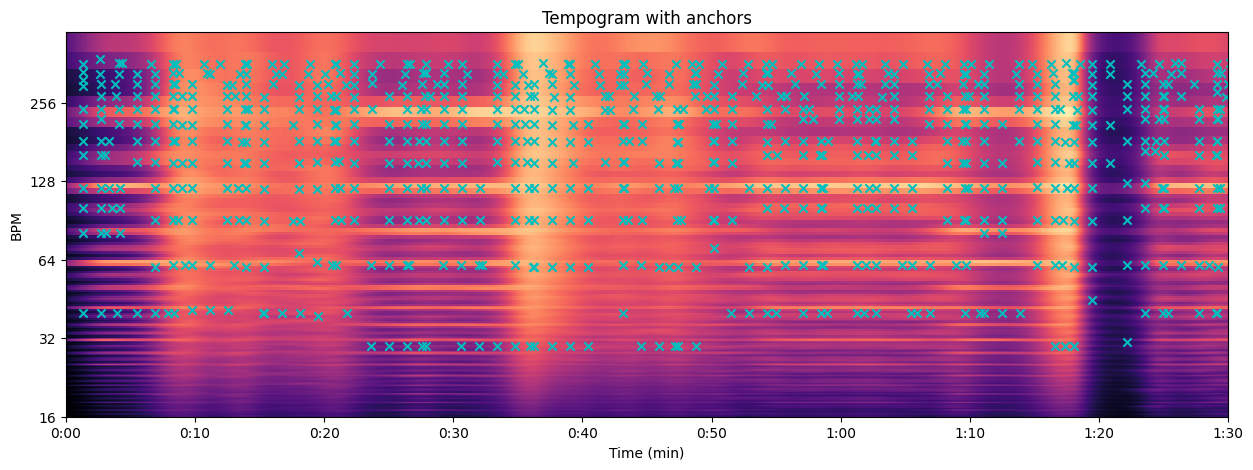

In [409]:
hop_length = 512
plt.figure(figsize=(15, 5))
librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='tempo')
plt.scatter(time_list, tempo_list, color='c', marker='x')
plt.xlim([0, 90])
plt.xlabel("Time (min)")
plt.title("Tempogram with anchors")
plt.show()

In [410]:
audio_path = "/content/drive/MyDrive/KTH/data/Dimitri Vegas, Moguai & Like Mike feat. Julian Peretta - Body Talk (Mammoth).wav"
# audio_path = "/content/drive/MyDrive/KTH/data/Q6querywithnoise.wav"

one_sec_temp, sr, duration = make_tempogram(audio_path, 2, 10)

In [411]:
time_list, tempo_list = compute_anchors(one_sec_temp, sr)
fingerprint = compute_fingerprints(time_list, tempo_list)


In [412]:
match_dict = {}
query = fingerprint
for i in range(len(all_fingerprints)):
      matches = compare_fingerprintsLab3(query, all_fingerprints[i])
      # matching_times = matching_fingerprint(query, all_fingerprints[i])
      # matches = compare_fingerprints(query, all_fingerprints[i])
      # match_dict[i] = len(matching_times)
      match_dict[i] = matches

max_key = max(match_dict, key=match_dict.get)
max_score = match_dict[max_key]
print(f'Max number of matches are {max_score}, for audio {max_key}')
print(match_dict)

Max number of matches are 432, for audio 10
{0: 38, 1: 36, 2: 37, 3: 36, 4: 41, 5: 42, 6: 9, 7: 9, 8: 244, 9: 366, 10: 432, 11: 258}
